# SRCNN for BSDS 500 super-resolution Dataset

姓名：盘国萍$\quad\quad$  学号：19040100128

## 理论基础

图像超分辨率问题研究的是在输入一张低分辨率图像时（low resolution，LR），如何得到一张高分辨率图像（high resolution，HR）。

实现超分辨有以下几种方法：
- 传统：
    - 基于插值：如**最近邻插值**、**双线性插值**、**双三次插值**等算法</br>
    </br>
    - 基于退化模型：从图像的降质退化模型出发，假定高分辨图像是通过适当的运动、模糊和噪声才产生低分辨图像的，则可以通过获取**低分辨图像的关键信息**，利用未知**超分辨图像的先验知识**来约束分辨图像的生成。如**迭代反投影法**、**凸集投影法**和**最大后验概率法**等
    </br>
    </br>
    - 基于学习：对大量数据进行学习，获得低分辨率图像与超分辨率图像的映射关系。如**流形学习**、**稀疏编码**等
    

- 基于深度学习：

$\quad \quad$由于深度学习能利用多层非线性变换提取数据的高层抽象特征，能够对低分辨率图像的主要特征进行捕捉，同时经过映射后，与真实的超分辨率图像进行损失计算，进而完成映射关系的优化，较强的特征捕捉能力为重建后的效果进行了保障，常见算法有：**SRCNN**、**ESPCN**等

> 本次实验主要使用最经典的超分辨模型SRCNN来完成

## import modules

In [42]:
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import glob
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import os
import copy

## 数据处理

[np.rot](https://www.cnblogs.com/zhaoyingjie/p/14703742.html)

In [43]:
def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))


def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


In [44]:
class BSDS500_Dataset(Dataset):
    def __init__(self,img_dir,transform=None,target_transform=None):
        super(BSDS500_Dataset, self).__init__()

        self.img_dir = img_dir
        self.img_path = glob.glob1(img_dir,'*.jpg')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):

        return len(self.img_path)

    def __getitem__(self, item):
        img = cv2.imread(os.path.join(self.img_dir,self.img_path[item]))[:-1,:-1,[2,1,0]]

        # img rotation for the same shape
        h,w = img.shape[:-1]
        if h>w:
            img = np.rot90(img)
        
        # down sampling
        X = img[::2,::2].copy()
        
        # CUBIC
        lh,lw = X.shape[:-1]
        X = cv2.resize(X,(lw*2,lh*2),cv2.INTER_CUBIC)
        X = convert_rgb_to_y(X)
        
        y = img.copy()
        y = convert_rgb_to_y(y)
        
        if self.transform:
            X = self.transform(X)

        if self.target_transform:
            y = self.target_transform(y)

        # ToTensor
        X = torch.from_numpy(X).float().unsqueeze(0)/255.0
        y = torch.from_numpy(y).float().unsqueeze(0)/255.0

        return X,y

## 图像质量评价

常用评价指标:
- 结构相似性指数（structural similarity index，SSIM）
- MSSIM
- PSNR 峰值信噪比（和MSE挂钩）
- MOS平均意见得分
- 学习感知图像块相似度(Learned Perceptual Image Patch Similarity, LPIPS)，又称感知损失(perceptual loss)

资料：
- https://www.cnblogs.com/h694879357/p/15521273.html

**本实验使用LPIPS**

    学习感知图像块相似度(Learned Perceptual Image Patch Similarity, LPIPS)也称为“感知损失”(perceptual loss)，用于度量两张图像之间的差别。来源于CVPR2018的一篇论文《The Unreasonable Effectiveness of Deep Features as a Perceptual Metric》。
    
    该度量标准学习生成图像到Ground Truth的反向映射强制生成器学习从假图像中重构真实图像的反向映射，并优先处理它们之间的感知相似度。LPIPS 比传统方法（比如L2/PSNR, SSIM, FSIM）更符合人类的感知情况。LPIPS的值越低表示两张图像越相似，反之，则差异越大。

给定Ground Truth目标图像 $x$ 和含噪声图像失真块 $x_0$

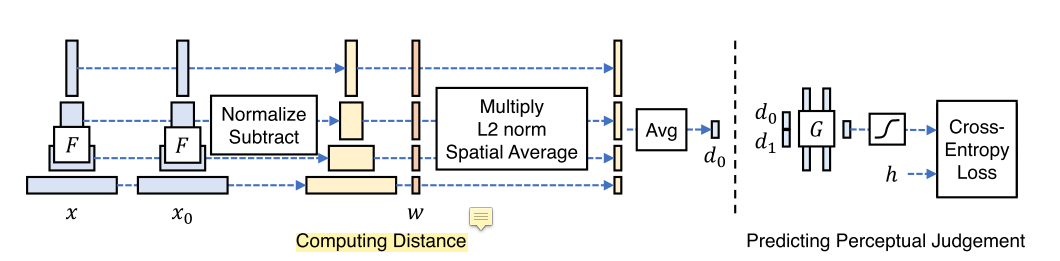


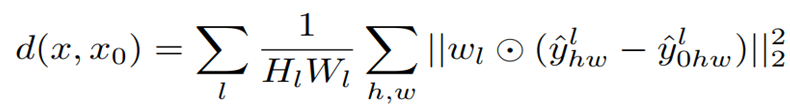

其中，$d$ 为 $x_0$ 和 $x$ 之间的距离。从 $L$ 层提取特征堆，并在通道维度进行单位规格化。利用向量 $w_l$ 来放缩激活通道数，最终计算 $L2$ 距离。最后在空间上进行平均，在通道上进行求和。

资料：
- [Gitbub LPIPS](https://github.com/richzhang/PerceptualSimilarity)
- [Pytorch MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html?)
- [CSDN LPIPS代码教程](https://blog.csdn.net/weixin_43466026/article/details/119898304)
- [知乎 LPIPS理论分析](https://zhuanlan.zhihu.com/p/162070277) 


In [45]:
#!pip install lpips

In [46]:
import lpips

In [47]:
class LPIP_LOSS(nn.Module):
    '''

    Brief:
        这个方法是利用LPIPS作为感知损失+MSE损失作为约束


    Params:
        net:'vgg' or 'alex' [default='vgg']
        lpips_weight: the weight of lpips_loss    [default=1.0]
        model_path: the path of pretrained_model.pth
        device: 'cuda' or 'cpu [default='cpu']

    Return:
          loss

    '''
    def __init__(self,net='vgg',lpips_weight=1.0,model_path='vgg16-397923af.pth',device='cpu',):
        super(LPIP_LOSS, self).__init__()

        if net == 'vgg':
            model_path = 'model/vgg16-397923af.pth'
            
        elif net == 'alex':
            model_path = 'model/alexnet-owt-7be5be79.pth'
        
        self.lpips_loss = lpips.LPIPS(net=net,
                                      model_path=model_path).to(device=device)

        self.lpips_weight = lpips_weight

        self.mse_loss = nn.MSELoss()

    def forward(self,pred,target):

        lpips_loss = self.lpips_loss.forward(pred,target).reshape(-1,1)
        mse_loss = self.mse_loss(pred,target)

        lpips_loss = torch.mean(lpips_loss)

        loss = lpips_loss*self.lpips_weight + mse_loss

        return loss

## 构建模型

### SRCNN的理论基础

SRCNN算法的框架，SRCNN将深度学习与传统稀疏编码之间的关系作为依据，将3层网络划分为：
- 图像块提取(Patch extraction and representation)
- 非线性映射(Non-linear mapping)
- 重建(Reconstruction)

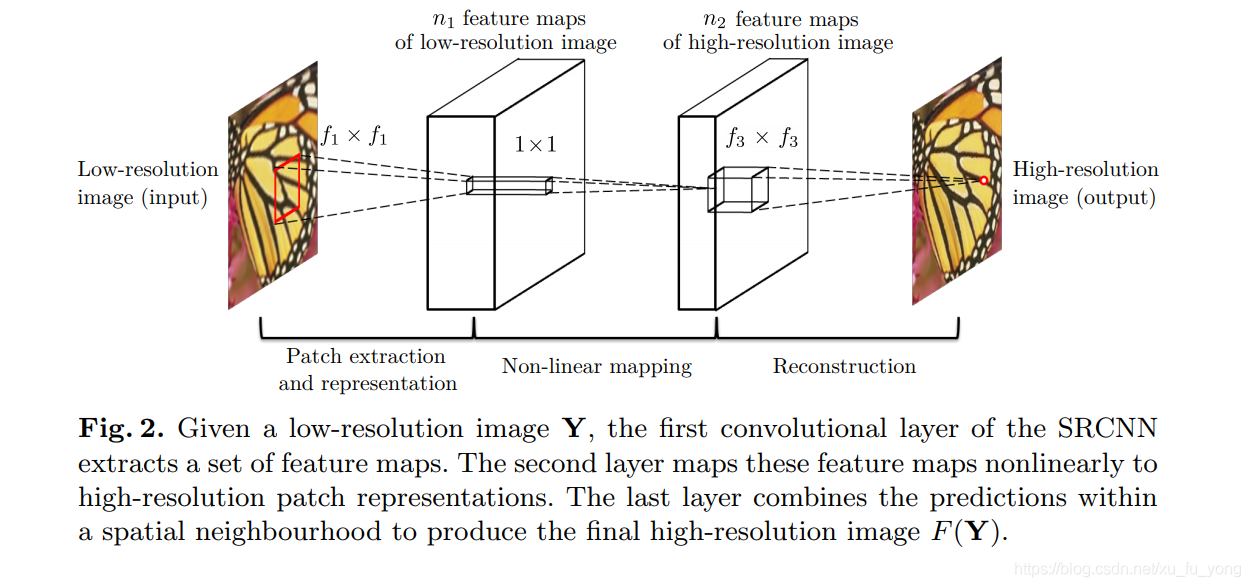

过程：
- SRCNN只是对 `YCbCr的Y通道` 进行重建
- 输入的低分辨率图像进行双三次插值进行放大到目标图像
- 图像块处理：对放大后的低分辨率图像进行conv+relu进行特征提取
- 非线性映射：将低分辨率图的特征映射到高分辨率图的特征
- 重建：根据高分辨率图的特征来聚合生成最终的高分辨率图像

简化超分辨重建示意图：
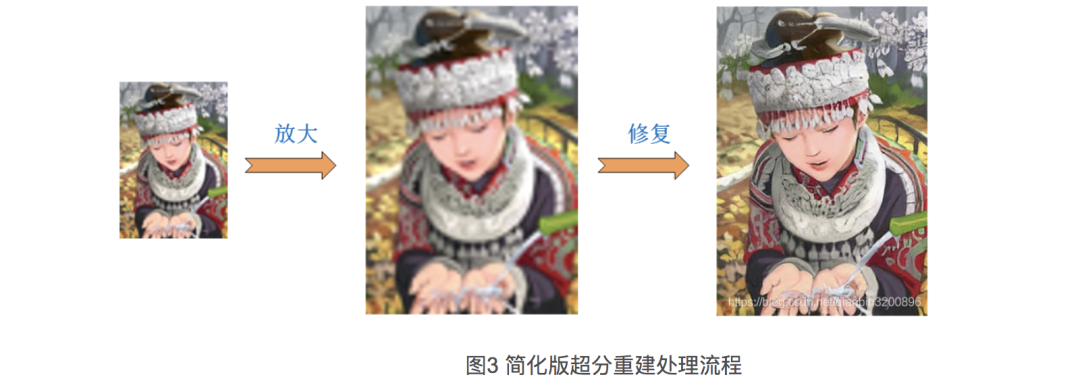

资料：
- [网络搭建参考](http://t.zoukankan.com/lwp-nicol-p-15273179.html)
- [超分辨综述](https://blog.csdn.net/demm868/article/details/112418431)
- [b站超分辨基础视频](https://www.bilibili.com/video/BV1pE411H7vd?spm_id_from=333.999.0.0)

- [CSDN 超分辨合集](
https://blog.csdn.net/xu_fu_yong/category_9135893.html?spm=1001.2014.3001.5482)

### 添加噪声

    为数据添加噪声，目的是使得结果更加鲁棒

In [48]:
def add_noise(img,amplitude=0.1):
    noise = torch.randn(img.shape).type_as(img)*amplitude
    noise_img = img + noise
    return torch.clamp(noise_img,min=0.0,max=1.0)

### SRCNN

In [49]:
class SRCNN(nn.Module):
    def __init__(self,in_channels=1):
        super(SRCNN, self).__init__()

        self.patch_extraction = nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=9,padding=4)
        self.non_linear_mapping = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1)
        self.reconstruction = nn.Conv2d(in_channels=32,out_channels=in_channels,kernel_size=5,padding=2)

        self.relu = nn.ReLU(inplace=True)
#         self.scale = scale

    def forward(self,x):
#         h,w = x.shape[2:]
#         output = torch.nn.functional.interpolate(x,(self.scale*h,self.scale*w),mode='bicubic',align_corners=False)
        output = self.relu(self.patch_extraction(x))
        output = self.relu(self.non_linear_mapping(output))
        output = self.reconstruction(output)

        return output

## Train

In [50]:
def train_model(model,train_loader,scheduler=None,num_epochs = 2):
    best_model_dict = copy.deepcopy(model.state_dict())
    best_score = 0.0
    model.train()

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch:^5d}/{num_epochs-1:^5d}')
        print("----------------------------------------------")

        if scheduler is not None:
            scheduler.step()

        score = 0.0
        total_loss = 0.0
        
        for i,(X,y) in enumerate(tqdm(train_loader)):
            time.sleep(0.01)
            X,y = X.to(device),y.to(device)
            X = add_noise(X)
            optimizer.zero_grad()

            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            
            outputs = model(X)
            loss = loss_fn(outputs,y)

            
            loss.backward()
            optimizer.step()
            
            total_loss +=loss*X.shape[0]
                        
            if i%2 == 0:
                print(f"Loss:{loss}")
                
        total_loss /= len(train_data)
        if score > best_score:
            best_score  = score
            best_model_dict = copy.deepcopy(model.state_dict())
        print(f'Total Loss:{total_loss}')

    return best_model_dict

In [51]:
train_val_dir = 'Dataset/bsds500/trainval/'
test_dir = 'Dataset/bsds500/test/'

In [52]:
train_data = BSDS500_Dataset(train_val_dir)
test_data = BSDS500_Dataset(test_dir)

In [53]:
batch_size = 2

In [54]:
train_loader = DataLoader(train_data,batch_size=batch_size)
test_loader = DataLoader(test_data,batch_size=batch_size)

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
net = SRCNN().to(device)

In [81]:
# loss_fn = LPIP_LOSS(device=device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [82]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.1)

In [83]:
best_model_dict = train_model(net,train_loader,scheduler=lr_scheduler)

E:\Anaconda\envs\torch1.10\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch:   0  /  1  
----------------------------------------------


  1%|▌                                                                                 | 1/150 [00:00<00:20,  7.32it/s]

Loss:0.00957867968827486


  2%|█▋                                                                                | 3/150 [00:00<00:16,  9.10it/s]

Loss:0.010723914951086044


  3%|██▋                                                                               | 5/150 [00:00<00:13, 10.48it/s]

Loss:0.018170280382037163


  5%|███▊                                                                              | 7/150 [00:00<00:13, 11.00it/s]

Loss:0.006942612584680319


  6%|████▉                                                                             | 9/150 [00:00<00:12, 10.91it/s]

Loss:0.00472717359662056


  7%|█████▉                                                                           | 11/150 [00:01<00:12, 10.79it/s]

Loss:0.006639484316110611


  9%|███████                                                                          | 13/150 [00:01<00:12, 11.05it/s]

Loss:0.007545801345258951


 10%|████████                                                                         | 15/150 [00:01<00:12, 10.69it/s]

Loss:0.006711521185934544


 11%|█████████▏                                                                       | 17/150 [00:01<00:11, 11.23it/s]

Loss:0.008991955779492855


 13%|██████████▎                                                                      | 19/150 [00:01<00:11, 11.36it/s]

Loss:0.006836501881480217


 14%|███████████▎                                                                     | 21/150 [00:01<00:11, 11.02it/s]

Loss:0.007365848403424025


 17%|█████████████▌                                                                   | 25/150 [00:02<00:11, 10.72it/s]

Loss:0.005700348876416683
Loss:0.009259264916181564


 19%|███████████████▋                                                                 | 29/150 [00:02<00:11, 10.61it/s]

Loss:0.007373672444373369
Loss:0.007083319127559662


 22%|█████████████████▊                                                               | 33/150 [00:03<00:10, 11.59it/s]

Loss:0.009017707780003548
Loss:0.007399561814963818


 25%|███████████████████▉                                                             | 37/150 [00:03<00:09, 11.43it/s]

Loss:0.006690027192234993
Loss:0.00402824254706502


 27%|██████████████████████▏                                                          | 41/150 [00:03<00:09, 11.50it/s]

Loss:0.004650761839002371
Loss:0.005069916136562824


 30%|████████████████████████▎                                                        | 45/150 [00:04<00:08, 12.06it/s]

Loss:0.002702912548556924
Loss:0.0028448395896703005


 33%|██████████████████████████▍                                                      | 49/150 [00:04<00:08, 12.35it/s]

Loss:0.002124543534591794
Loss:0.005025935359299183


 35%|████████████████████████████▌                                                    | 53/150 [00:04<00:08, 12.00it/s]

Loss:0.0060763247311115265
Loss:0.011875775642693043


 38%|██████████████████████████████▊                                                  | 57/150 [00:05<00:07, 11.75it/s]

Loss:0.0028272399213165045
Loss:0.002620487241074443


 41%|████████████████████████████████▉                                                | 61/150 [00:05<00:07, 11.97it/s]

Loss:0.0059226565062999725
Loss:0.0029903079848736525


 43%|███████████████████████████████████                                              | 65/150 [00:05<00:07, 11.99it/s]

Loss:0.0026959921233356
Loss:0.005275859963148832


 46%|█████████████████████████████████████▎                                           | 69/150 [00:06<00:06, 12.33it/s]

Loss:0.004170261789113283
Loss:0.00438300147652626


 49%|███████████████████████████████████████▍                                         | 73/150 [00:06<00:06, 11.64it/s]

Loss:0.005898698233067989
Loss:0.003264429746195674


 51%|█████████████████████████████████████████▌                                       | 77/150 [00:06<00:06, 11.80it/s]

Loss:0.005629086401313543
Loss:0.00430072657763958


 53%|██████████████████████████████████████████▋                                      | 79/150 [00:06<00:05, 12.01it/s]

Loss:0.003819409990683198


 55%|████████████████████████████████████████████▊                                    | 83/150 [00:07<00:06, 11.14it/s]

Loss:0.0030262970831245184
Loss:0.004440124146640301


 58%|██████████████████████████████████████████████▉                                  | 87/150 [00:07<00:05, 10.87it/s]

Loss:0.004511252511292696
Loss:0.00489005958661437


 61%|█████████████████████████████████████████████████▏                               | 91/150 [00:08<00:05, 10.81it/s]

Loss:0.004356248304247856
Loss:0.0016557388007640839


 63%|███████████████████████████████████████████████████▎                             | 95/150 [00:08<00:05, 10.89it/s]

Loss:0.004105629399418831
Loss:0.005330823827534914


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [00:08<00:04, 11.49it/s]

Loss:0.007539515849202871
Loss:0.002410688903182745


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [00:09<00:04, 11.02it/s]

Loss:0.0029827221296727657
Loss:0.0022838059812784195


 71%|█████████████████████████████████████████████████████████                       | 107/150 [00:09<00:03, 11.46it/s]

Loss:0.002724692225456238
Loss:0.00285315397195518


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [00:09<00:03, 11.35it/s]

Loss:0.004088704474270344
Loss:0.004229994025081396


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [00:09<00:03, 10.81it/s]

Loss:0.0025618926156312227


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [00:10<00:03, 10.09it/s]

Loss:0.0028179618529975414
Loss:0.0036008760798722506


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [00:10<00:02, 10.40it/s]

Loss:0.0038191168569028378
Loss:0.0022204674314707518


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [00:11<00:02, 10.70it/s]

Loss:0.0023478746879845858
Loss:0.0013783087488263845


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [00:11<00:01, 10.85it/s]

Loss:0.0036826233845204115
Loss:0.002331234049052


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [00:11<00:01, 10.52it/s]

Loss:0.00340333953499794


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [00:12<00:01, 10.08it/s]

Loss:0.0031001856550574303
Loss:0.005625334568321705


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [00:12<00:01, 10.17it/s]

Loss:0.0021642292849719524


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [00:12<00:01,  9.80it/s]

Loss:0.0026891359593719244


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [00:12<00:00,  9.92it/s]

Loss:0.006950723472982645
Loss:0.0016965536633506417


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [00:13<00:00, 10.03it/s]

Loss:0.002640765393152833
Loss:0.0030593571718782187


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:13<00:00, 11.06it/s]


Loss:0.003235498908907175
Total Loss:0.0048421695828437805
Epoch:   1  /  1  
----------------------------------------------


  1%|▌                                                                                 | 1/150 [00:00<00:15,  9.46it/s]

Loss:0.003244730643928051


  2%|█▋                                                                                | 3/150 [00:00<00:14, 10.36it/s]

Loss:0.0053136833012104034


  3%|██▋                                                                               | 5/150 [00:00<00:13, 10.46it/s]

Loss:0.004934818018227816
Loss:0.0021241214126348495

  6%|████▉                                                                             | 9/150 [00:00<00:13, 10.80it/s]


Loss:0.002412649104371667


  9%|███████                                                                          | 13/150 [00:01<00:11, 11.81it/s]

Loss:0.0015377794625237584
Loss:0.003860236844047904


 11%|█████████▏                                                                       | 17/150 [00:01<00:10, 12.25it/s]

Loss:0.003858063369989395
Loss:0.0017308960668742657


 14%|███████████▎                                                                     | 21/150 [00:01<00:11, 11.17it/s]

Loss:0.0033066445030272007
Loss:0.004440293647348881


 17%|█████████████▌                                                                   | 25/150 [00:02<00:11, 10.76it/s]

Loss:0.0018621589988470078
Loss:0.004640773870050907


 18%|██████████████▌                                                                  | 27/150 [00:02<00:11, 11.03it/s]

Loss:0.00436231167986989


 21%|████████████████▋                                                                | 31/150 [00:02<00:10, 10.89it/s]

Loss:0.003527737455442548
Loss:0.004544916562736034


 23%|██████████████████▉                                                              | 35/150 [00:03<00:09, 11.59it/s]

Loss:0.0037812066730111837
Loss:0.003463946282863617


 26%|█████████████████████                                                            | 39/150 [00:03<00:09, 12.16it/s]

Loss:0.002674014773219824
Loss:0.0024147192016243935


 29%|███████████████████████▏                                                         | 43/150 [00:03<00:08, 11.90it/s]

Loss:0.0027252512518316507
Loss:0.001953734550625086


 31%|█████████████████████████▍                                                       | 47/150 [00:04<00:09, 11.17it/s]

Loss:0.0019814802799373865
Loss:0.0015666300896555185


 33%|██████████████████████████▍                                                      | 49/150 [00:04<00:08, 11.33it/s]

Loss:0.003357179695740342


 35%|████████████████████████████▌                                                    | 53/150 [00:04<00:10,  9.19it/s]

Loss:0.003718650434166193
Loss:0.008785481564700603


 37%|█████████████████████████████▋                                                   | 55/150 [00:05<00:09,  9.96it/s]

Loss:0.0019248641328886151


 39%|███████████████████████████████▊                                                 | 59/150 [00:05<00:08, 10.40it/s]

Loss:0.001971839927136898
Loss:0.004726075567305088


 41%|████████████████████████████████▉                                                | 61/150 [00:05<00:08, 11.06it/s]

Loss:0.0022326998878270388


 43%|███████████████████████████████████                                              | 65/150 [00:05<00:08, 10.53it/s]

Loss:0.0021327456925064325
Loss:0.0032871977891772985


 46%|█████████████████████████████████████▎                                           | 69/150 [00:06<00:07, 10.81it/s]

Loss:0.0032921575475484133
Loss:0.003640095004811883


 47%|██████████████████████████████████████▎                                          | 71/150 [00:06<00:07, 11.28it/s]

Loss:0.004868128802627325


 50%|████████████████████████████████████████▌                                        | 75/150 [00:06<00:07, 10.47it/s]

Loss:0.0023803547956049442
Loss:0.004493908490985632


 53%|██████████████████████████████████████████▋                                      | 79/150 [00:07<00:06, 10.17it/s]

Loss:0.0036877053789794445
Loss:0.0028023638296872377


 55%|████████████████████████████████████████████▊                                    | 83/150 [00:07<00:06, 10.50it/s]

Loss:0.0025008022785186768
Loss:0.003361385315656662


 58%|██████████████████████████████████████████████▉                                  | 87/150 [00:08<00:06, 10.21it/s]

Loss:0.0036306690890341997
Loss:0.004018260631710291


 61%|█████████████████████████████████████████████████▏                               | 91/150 [00:08<00:05, 11.11it/s]

Loss:0.0037231764290481806
Loss:0.001584303448908031


 63%|███████████████████████████████████████████████████▎                             | 95/150 [00:08<00:05, 10.68it/s]

Loss:0.0035285521298646927
Loss:0.00494763208553195


 65%|████████████████████████████████████████████████████▍                            | 97/150 [00:08<00:04, 10.78it/s]

Loss:0.0069946590811014175
Loss:0.001899990253150463


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [00:09<00:04, 10.58it/s]

Loss:0.00271417573094368


 70%|████████████████████████████████████████████████████████                        | 105/150 [00:09<00:04, 10.38it/s]

Loss:0.0020487462170422077
Loss:0.0023940904065966606


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [00:10<00:04, 10.11it/s]

Loss:0.002628111746162176
Loss:0.0039809588342905045


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [00:10<00:03, 10.19it/s]

Loss:0.003855727147310972
Loss:0.002230050740763545


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [00:10<00:03,  9.74it/s]

Loss:0.0025930015835911036
Loss:0.00342815020121634


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [00:11<00:02,  9.90it/s]

Loss:0.0032775148283690214
Loss:0.002008195500820875


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [00:11<00:02, 10.51it/s]

Loss:0.002264355542138219
Loss:0.0013255837839096785


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [00:12<00:01, 10.51it/s]

Loss:0.003412895370274782
Loss:0.002268579788506031


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [00:12<00:01, 10.29it/s]

Loss:0.0032427485566586256
Loss:0.0029755053110420704


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [00:12<00:01, 10.28it/s]

Loss:0.005427446682006121
Loss:0.0020932413171976805


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [00:13<00:00, 10.12it/s]

Loss:0.002656554337590933
Loss:0.006734427064657211


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [00:13<00:00, 10.34it/s]

Loss:0.001645250478759408
Loss:0.002564607420936227


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [00:14<00:00, 10.02it/s]

Loss:0.0030341967940330505
Loss:0.0031869071535766125


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.57it/s]

Total Loss:0.0031193289905786514


In [84]:
origin_img = cv2.imread('Dataset/bsds500/trainval/20069.jpg')[:-1,:-1,[2,0,1]]

In [85]:
limg = origin_img[::2,::2]
h,w = origin_img.shape[:-1]
cubic = cv2.resize(limg,(w,h),cv2.INTER_CUBIC)

In [86]:
srimg = np.array(cubic).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(srimg)

In [87]:
y = ycbcr[...,0]
y/= 255.0
y = torch.from_numpy(y).to(device)
y = y.unsqueeze(0).unsqueeze(0)

In [88]:
y.shape

torch.Size([1, 1, 480, 320])

In [89]:
net.eval()
with torch.no_grad():
    preds = net(y).clamp(0.0,1.0)
preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

In [90]:
output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)

(-0.5, 319.5, 479.5, -0.5)

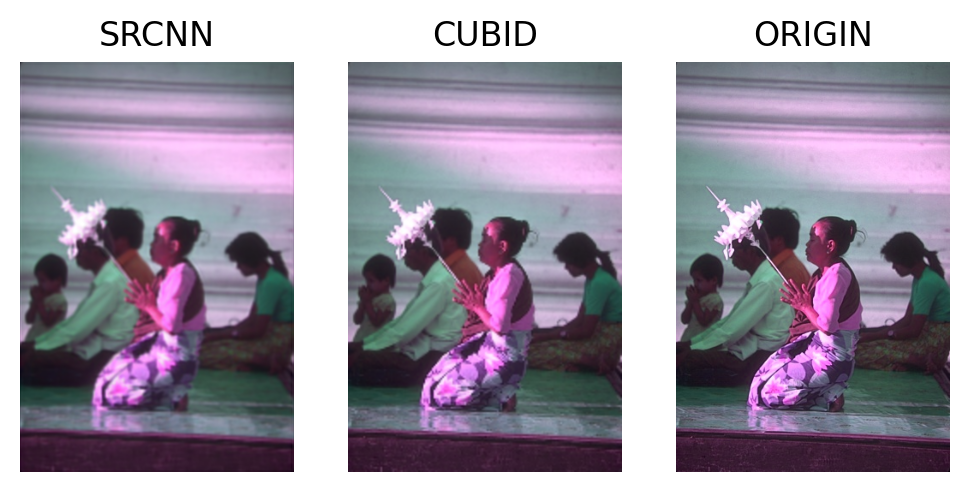

In [91]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,dpi=200)
ax1.imshow(output)
ax1.set_title('SRCNN')
ax1.axis('off')
ax2.imshow(cubic)
ax2.axis('off')
ax2.set_title('CUBID')
ax3.imshow(origin_img)
ax3.set_title('ORIGIN')
ax3.axis('off')

## Test

In [92]:
def test(model,test_loader,best_model_dict=None):
    model.eval()
    if best_model_dict is not None:
        model.load_state_dict(best_model_dict)

    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()

    for batch,(X,y) in enumerate(tqdm(test_loader)):
        time.sleep(0.01)
        with torch.no_grad():
            X,y = X.to(device),y.to(device)
            pred = model(X)
            loss = loss_fn(pred,y)
            print(f'loss:{loss:>7f}')

In [93]:
test(net,test_loader)

  4%|███▎                                                                              | 4/100 [00:00<00:06, 15.22it/s]

loss:0.002468
loss:0.000729
loss:0.004538
loss:0.004684


  6%|████▉                                                                             | 6/100 [00:00<00:06, 14.72it/s]

loss:0.001147
loss:0.000836
loss:0.000783


  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.36it/s]

loss:0.000827
loss:0.002397
loss:0.003938

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 12.66it/s]


loss:0.002642
loss:0.001001
loss:0.003497


 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 13.11it/s]

loss:0.002580
loss:0.003464
loss:0.000947


 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 13.26it/s]

loss:0.002861
loss:0.005359
loss:0.003639


 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 14.52it/s]

loss:0.001244
loss:0.002998
loss:0.003799
loss:0.002724


 26%|█████████████████████                                                            | 26/100 [00:01<00:04, 15.15it/s]

loss:0.002526
loss:0.002397
loss:0.001629
loss:0.001498


 30%|████████████████████████▎                                                        | 30/100 [00:02<00:04, 15.10it/s]

loss:0.002052
loss:0.002773
loss:0.001635
loss:0.001265


 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 15.50it/s]

loss:0.001984
loss:0.001792
loss:0.001595
loss:0.001925


 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:03, 15.61it/s]

loss:0.008003
loss:0.001509
loss:0.001262
loss:0.001265


 42%|██████████████████████████████████                                               | 42/100 [00:02<00:03, 15.75it/s]

loss:0.002074
loss:0.004170
loss:0.001502
loss:0.003778


 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 14.15it/s]

loss:0.001406
loss:0.003925
loss:0.002141


 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 14.76it/s]

loss:0.003043
loss:0.002654
loss:0.003434
loss:0.001802


 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 14.63it/s]

loss:0.001193
loss:0.001979
loss:0.001847


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:03<00:03, 13.71it/s]

loss:0.003618
loss:0.001577
loss:0.001685


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 14.34it/s]

loss:0.001613
loss:0.002521
loss:0.001530
loss:0.001902


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 14.70it/s]

loss:0.003787
loss:0.003017
loss:0.002294
loss:0.000837


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 15.08it/s]

loss:0.001652
loss:0.000961
loss:0.001669


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:04<00:01, 15.07it/s]

loss:0.006243
loss:0.001674
loss:0.001328
loss:0.002014


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:01, 15.36it/s]

loss:0.002333
loss:0.001933
loss:0.004426
loss:0.003261


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 14.66it/s]

loss:0.000724
loss:0.002246
loss:0.001693


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:05<00:01, 15.24it/s]

loss:0.002379
loss:0.002781
loss:0.001303
loss:0.003239


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:05<00:00, 15.55it/s]

loss:0.001157
loss:0.001830
loss:0.000700
loss:0.002746


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 15.13it/s]

loss:0.001150
loss:0.001529
loss:0.002523


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 14.73it/s]

loss:0.001081
loss:0.005694
loss:0.000384
loss:0.001354


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:06<00:00, 14.92it/s]

loss:0.003687
loss:0.006030
loss:0.001076
loss:0.001283


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.64it/s]

loss:0.001994
loss:0.002960
loss:0.004297


## Save Model

In [94]:
def save_model(model_path,best_model_dict):
    root_dir = 'model'
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)
    model_dir = os.path.join(root_dir, model_path)

    if not os.path.exists(model_dir):
        torch.save(best_model_dict, model_dir)
        print("Successfully save!")

    else:
        print(f"The model file:[{model_path}] is exits.")
        print(f"Replace or not?")
        print(f"Please input [Y/N]")
        signal = input()
        if signal == 'Y':
            torch.save(best_model_dict, model_dir)
            print("Successfully save!")
        else:
            print("Exit.")


In [95]:
save_model('SRCNN_for_BSDS500.pth',best_model_dict)

The model file:[SRCNN_for_BSDS500.pth] is exits.
Replace or not?
Please input [Y/N]
Y
Successfully save!


## Predict

In [106]:
def predict(model,img_path,input_size=(512,512)):
    img = cv2.imread(img_path)[:-1,:-1,[2,1,0]]
    
    h,w = img.shape[:-1]
    
    if h>w:
        img = np.rot90(img)
        
    X = img[::2,::2].copy()
    h,w = img.shape[:-1]
    cubic = cv2.resize(X,(w,h),cv2.INTER_CUBIC)

    srimg = np.array(cubic).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(srimg)
    
    y = ycbcr[...,0]/255.0
    y = torch.from_numpy(y).to(device)
    y = y.unsqueeze(0).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        pred = model(y).clamp(0.0,1.0)
        
        pred = pred.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)
        
        output = np.array([pred,ycbcr[...,1],ycbcr[...,2]]).transpose([1,2,0])
        output = np.clip(convert_ycbcr_to_rgb(output),0.0,255.0).astype(np.uint8)
        
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,dpi=200)
        ax1.imshow(output)
        ax1.set_title('SRCNN')
        ax1.axis('off')
        ax2.imshow(cubic)
        ax2.axis('off')
        ax2.set_title('CUBID')
        ax3.imshow(img)
        ax3.set_title('ORIGIN')
        ax3.axis('off')


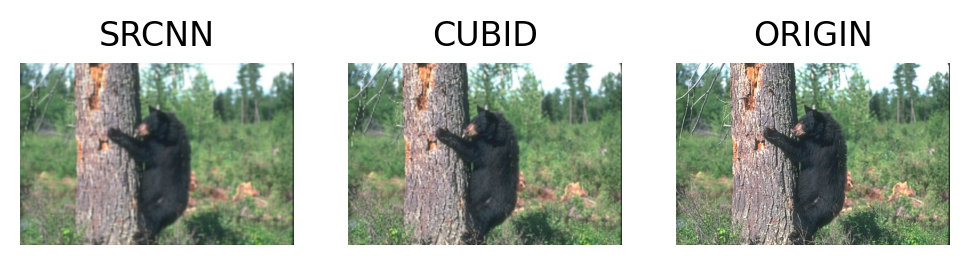

In [112]:
predict(net,'Dataset/bsds500/test/100039.jpg')